In [ ]:
# Text Mining with an Amazon Reviews Dataset
# Austin Diamond, Sean Teng, Nathan Lam

In [ ]:
#Import Libraries
import numpy as np
import re
import pickle
from sklearn.datasets import load_files
from collections import Counter
import matplotlib
import pandas as pd
from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier

#nltk imports
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.probability import FreqDist
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#Import Vader
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

#Error Handling
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# 1. Load the dataset from a compressed gz file.

In [ ]:
from google.colab import files
files.upload();

Saving Office_Products_5.json.gz to Office_Products_5.json.gz


In [ ]:
reviews = pd.read_csv("Office_Products_5.json.gz", compression="gzip", header=0, sep=",", quotechar='"', on_bad_lines='skip')

In [ ]:
len(reviews)

707191

In [ ]:
reviews.sample(5)

,"{""overall"": 4.0","""verified"": true","""reviewTime"": ""11 7","2017""","""reviewerID"": ""A2NIJTYWADLK57""","""asin"": ""0140503528""","""style"": {""Format:"": "" Board book""}","""reviewerName"": ""cotton clay""","""reviewText"": ""kids like story BUT while i really wanted a board book this one is just so small. wish larger""","""summary"": ""good story","small size book though""","""unixReviewTime"": 1510012800}"
427692,"{""overall"": 4.0","""verified"": true","""reviewTime"": ""04 21","2016""","""reviewerID"": ""A23HJTWI4VVTNP""","""asin"": ""B00BT55B54""","""reviewerName"": ""kherm1221""","""reviewText"": ""These are great boxes but for ...","sturdy and solid for secure shipping.""","""summary"": ""Good","strong boxes""","""unixReviewTime"": 1461196800}"
381266,"{""overall"": 4.0","""verified"": true","""reviewTime"": ""04 3","2018""","""reviewerID"": ""A3ANW5BON731U3""","""asin"": ""B006XGCQDY""","""reviewerName"": ""Heart""","""reviewText"": ""love them","but think it's a big price for only 50""","""summary"": ""works well""","""unixReviewTime"": 1522713600}",NaN
565280,"{""overall"": 2.0","""verified"": true","""reviewTime"": ""08 22","2016""","""reviewerID"": ""A1UA21VGKC1P0T""","""asin"": ""B00VTOJYD0""","""reviewerName"": ""Amelia Earhart""","""reviewText"": ""One of the cartridges was empt...","Amazon did correct.""","""summary"": ""Two Stars""","""unixReviewTime"": 1471824000}",NaN
442153,"{""overall"": 5.0","""verified"": true","""reviewTime"": ""12 21","2015""","""reviewerID"": ""A3CV099NIU2S37""","""asin"": ""B00D5PXWJS""","""reviewerName"": ""Busy Grandmum""","""reviewText"": ""I always order this ink and we...","""summary"": ""Excellent ink""","""unixReviewTime"": 1450656000}",NaN,NaN
425448,"{""overall"": 4.0","""verified"": false","""reviewTime"": ""11 19","2013""","""reviewerID"": ""A1GQRGB8FGSLIZ""","""asin"": ""B00BMLQRQC""","""style"": {""Size:"": "" Single""}","""reviewerName"": ""Amazon Customer""","""reviewText"": ""I also have a swingline pencil...",while Westcott is not as good as that one it ...,"""summary"": ""Works well","not the fastest sharpener"""


In [ ]:
reviews.columns

Index(['{"overall": 4.0', ' "verified": true', ' "reviewTime": "11 7',
       ' 2017"', ' "reviewerID": "A2NIJTYWADLK57"', ' "asin": "0140503528"',
       ' "style": {"Format:": " Board book"}',
       ' "reviewerName": "cotton clay"',
       ' "reviewText": "kids like story BUT while i really wanted a board book this one is just so small.  wish larger"',
       ' "summary": "good story', ' small size book though"',
       ' "unixReviewTime": 1510012800}'],
      dtype='object')

# 2. Focus on rating, review, and summary columns

In [ ]:
# create a dataframe with the sentence column and helpful column
focus_reviews = reviews.iloc[:, [0,8]]

In [ ]:
focus_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707191 entries, 0 to 707190
Data columns (total 2 columns):
 #   Column                                                                                                           Non-Null Count   Dtype 
---  ------                                                                                                           --------------   ----- 
 0   {"overall": 4.0                                                                                                  707191 non-null  object
 1    "reviewText": "kids like story BUT while i really wanted a board book this one is just so small.  wish larger"  707107 non-null  object
dtypes: object(2)
memory usage: 10.8+ MB


In [ ]:
# rename column headers
focus_reviews.columns.values[0] = "Rating"
focus_reviews.columns.values[1] = "Review"

In [ ]:
focus_reviews.head()

,Rating,Review
0,"{""overall"": 4.0","""reviewText"": ""Bought this used and it came i..."
1,"{""overall"": 5.0","""reviewText"": ""Every story and book about Cor..."
2,"{""overall"": 5.0","""reviewText"": ""Corduroy gets a pocket....rive..."
3,"{""overall"": 5.0","""reviewText"": ""Love this book"""
4,"{""overall"": 5.0","""reviewText"": ""This is a lovely gentle simple..."


# 3. Randomly select 10000 reviews.

In [ ]:
# create a dataframe with 10000 random reviews
sample_reviews = focus_reviews.sample(n = 10000)

In [ ]:
focus_reviews.columns = ['Rating', 'Review']


In [ ]:
sample_reviews.head()

,Rating,Review
111959,"{""overall"": 5.0","""summary"": ""Binder is durable and I love usin..."
42979,"{""overall"": 5.0","""reviewerName"": ""Kenzie"""
551024,"{""overall"": 4.0","""reviewerName"": ""Daniel B."""
257137,"{""overall"": 5.0","""reviewerName"": ""Renee"""
228,"{""overall"": 5.0","""reviewText"": ""Cure and works well with marke..."


In [ ]:
sample_reviews.columns

Index(['Rating', 'Review'], dtype='object')

# Clean the rating column


In [ ]:
sample_reviews.columns = sample_reviews.columns.str.strip()

In [ ]:
sample_reviews['Rating'] = sample_reviews['Rating'].apply(lambda x: x.replace('"', ''))
sample_reviews['Rating'] = sample_reviews['Rating'].apply(lambda x: x.replace('{overall:', ''))

In [ ]:
sample_reviews.head()

,Rating,Review
111959,5.0,"""summary"": ""Binder is durable and I love usin..."
42979,5.0,"""reviewerName"": ""Kenzie"""
551024,4.0,"""reviewerName"": ""Daniel B."""
257137,5.0,"""reviewerName"": ""Renee"""
228,5.0,"""reviewText"": ""Cure and works well with marke..."


# 4. Preprocess the text data

In [ ]:
# Cast Review column as a string
sample_reviews['Review'] = sample_reviews['Review'].astype(str)

In [ ]:
# Remove the extra information and extract the review text
sample_reviews['Review'] = sample_reviews['Review'].str.replace('"reviewText": ', '').str.strip('"')

In [ ]:
wpt=nltk.WordPunctTokenizer()

In [ ]:
stop_words=nltk.corpus.stopwords.words('english')

In [ ]:
def normalize_document (doc):
    #4a. lowercase
    doc=doc.lower()

    #4b. remove special characters\whitespace
    doc=re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A) #re.I ignore case sensitive, ASCII-only matching
    doc=doc.strip()

    #4c. tokenize document
    tokens=wpt.tokenize(doc)

    #4d. filter stopwords out of document
    filtered_tokens=[token for token in tokens if token not in stop_words]
    #re-create document from filtered tokens
    doc=' '.join(filtered_tokens)

    return doc


In [ ]:
norm_sample_reviews = pd.DataFrame()

In [ ]:
norm_sample_reviews['Review'] = sample_reviews['Review'].apply(normalize_document)

In [ ]:
norm_sample_reviews.sample(5)

,Review
125927,reviewername teresa johnson
245303,style fine point
237235,great job
612760,summary five stars
318277,brothernfor tried save money brand xngave head...


In [ ]:
norm_sample_reviews['Review'] = norm_sample_reviews['Review'].apply(lambda x: x.replace('summary', ''))
norm_sample_reviews['Review'] = norm_sample_reviews['Review'].apply(lambda x: x.replace('reviewername', ''))
norm_sample_reviews['Review'] = norm_sample_reviews['Review'].apply(lambda x: x.replace('star', ''))

In [ ]:
#4e. lemmatize
wordnet_lemmatizer = WordNetLemmatizer()
lemm_sample_reviews = pd.DataFrame()

def lemmatizer (doc):
  words = doc.split()
  words = [wordnet_lemmatizer.lemmatize(word,pos='v') for word in words]
  return ' '.join(words)

lemm_sample_reviews['Review'] = norm_sample_reviews['Review'].apply(lambda x:lemmatizer(x))

# 5. Create a frequency distribution of words (tokens) in the reviews.

In [ ]:
# Convert the column into a single string
reviews_string = ' '.join(lemm_sample_reviews['Review'])

# Create a frequency distribution using Counter
def preprocess (doc):
    # Split into tokens
    tokens = doc.split()
    return tokens

tokens = preprocess(reviews_string)
word_freq = Counter(tokens)

In [ ]:
# Print the most common words
for word, freq in word_freq.most_common(11):
    print(f"{word}: {freq}")

great: 1252
s: 1039
use: 995
work: 981
five: 839
good: 759
love: 521
color: 463
buy: 449
product: 435
pen: 432


# 6. Generate a word cloud to visualize the most common words in the reviews.

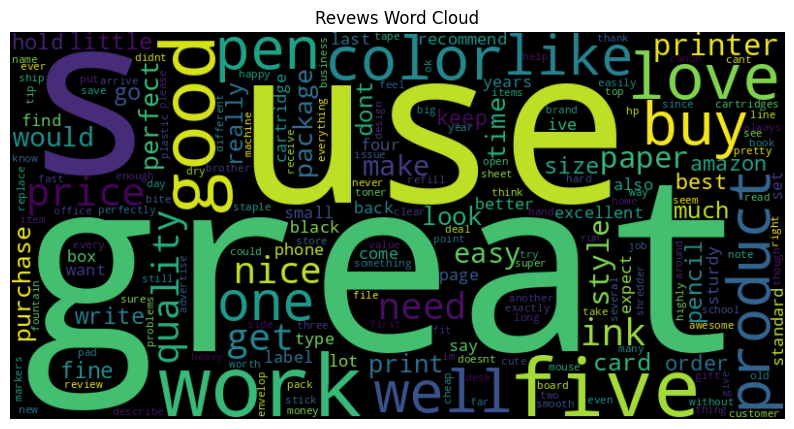

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(word_freq)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Revews Word Cloud")
plt.show()


# 7. Calculate the sentiment score for each review using VADER

In [ ]:
# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

sentiment_df = pd.DataFrame()

# Calculate sentiment scores
def get_sentiment_scores(review):
    return analyzer.polarity_scores(review)

# Copy the reviews column to the new df
sentiment_df['reviews'] = norm_sample_reviews['Review']
# Apply the sentiment analysis to the original df and create a new column in the new df for sentiment scores
sentiment_df['sentiment_scores'] = norm_sample_reviews['Review'].apply(get_sentiment_scores)

# Access the compound score from the sentiment_scores column (both in the new df)
sentiment_df['compound_score'] = sentiment_df['sentiment_scores'].apply(lambda x: x['compound'])

# Add an overall sentiment rating
sentiment_df['sentiment_scores'] = pd.cut(x=sentiment_df['compound_score'], bins=[-1, -0.000001, 0, 1], labels=['neg','neu','pos'])

# Print the dataframe with sentiment scores
sentiment_df

,reviews,sentiment_scores,compound_score
111959,binder durable love using store everything,pos,0.6369
42979,kenzie,neu,0.0000
551024,daniel b,neu,0.0000
257137,renee,neu,0.0000
228,cure works well markers magnets dont stick well,pos,0.4939
...,...,...,...
272756,awesome erasers,pos,0.6249
9767,amazon customer,pos,0.1779
293038,beat way buy labels product excellent price be...,pos,0.8519
329859,plug simple pry makes ready use wouldnt try pr...,pos,0.3612


# 8. Identify and print the top 5 positive and negative reviews based on sentiment scores.

In [ ]:
# Sort the dataframe by the 'compound_score' column
sorted_data = sentiment_df.sort_values('compound_score', ascending=False)

# Get the top 5 positive and negative reviews
top_positive_reviews = sorted_data.head(5)
top_negative_reviews = sorted_data.tail(5)

# Top 5 positive reviews
print("Top 5 Positive Reviews:")
for i, row in top_positive_reviews.iterrows():
    print(f"Review {i}: {row['reviews']} (Compound Score: {row['compound_score']})")

# Top 5 negative reviews
print("\nTop 5 Negative Reviews:")
for i, row in top_negative_reviews.iterrows():
    print(f"Review {i}: {row['reviews']} (Compound Score: {row['compound_score']})")


Top 5 Positive Reviews:
Review 549345: epsons perfection v scanner fantastic little document photo scanner may miss features larger pricey devices perfectly light occasional user file sharing features bundled software help scanner stand crowded marketnnndescriptionnnmeasuring x x w x x h lbs v perfect home small office use size lend modicum portability small form factor price point strip v anything bare essentials wont find autodocument feeder get fantastic little scanner requires attention users part generate fantastic quality scansnnthe face scanner features four buttons following order left rightn scan pdfn sendn copyn t scannnin box youll receiven scannern usb usbb micro cablen software cdn printed instructioninstallation guidennnusennfirst things first scanner supports usb definitely used first connected v tested regular dpi scan surprised long scanner took scan realized used one pcs front usb port ports switched usb port things moved along much quickernnthe scan bed great regular

# Classification Trees

In [ ]:
classifier_df = pd.DataFrame()
classifier_df = sentiment_df.drop('reviews', axis=1)
classifier_df = classifier_df.drop('sentiment_scores', axis=1)
classifier_df['rating'] = sample_reviews['Rating']
classifier_df

,compound_score,NB_Sentiment,rating
111959,0.6369,1,5.0
42979,0.0000,0,5.0
551024,0.0000,0,4.0
257137,0.0000,0,5.0
228,0.4939,1,5.0
...,...,...,...
272756,0.6249,1,5.0
9767,0.1779,1,5.0
293038,0.8519,1,5.0
329859,0.3612,1,5.0


In [ ]:
classifier_df.sample(10)

,compound_score,NB_Sentiment,rating
405494,0.6249,1,5.0
511367,0.0000,0,5.0
560726,0.0000,0,{image: [https://images-na.ssl-images-amazon.c...
336230,0.0000,0,5.0
49770,0.0000,0,4.0
312344,0.4404,1,5.0
649100,0.2023,1,4.0
364413,0.9584,1,5.0
667565,0.7964,1,5.0
478453,-0.6369,0,4.0


In [ ]:
# clean the rating column
classifier_df = classifier_df[classifier_df['rating'].str.contains('{') == False]

In [ ]:
classifier_df.sample(10)

,compound_score,NB_Sentiment,rating
594916,0.2732,1,5.0
162100,0.2732,1,5.0
554295,0.0000,0,5.0
612760,0.0000,0,5.0
107429,0.0000,0,5.0
69737,0.4404,1,5.0
73651,-0.1477,0,5.0
351510,0.6249,1,5.0
566373,0.7351,1,5.0
220034,0.4404,1,5.0


In [ ]:
classifier_df['']

In [ ]:
# perpare dataframe for NB Classifier
# create a new column that converts the sentiment score into numerical data
classifier_df['NB_Sentiment'] = sentiment_df.sentiment_scores.eq('pos').mul(1)

In [ ]:
# convert the new column to a category datatype
classifier_df['NB_Sentiment'] = classifier_df['NB_Sentiment'].astype(int)
classifier_df['rating'] = classifier_df['rating'].astype(float)

In [ ]:
classifier_df.dtypes

compound_score    float64
NB_Sentiment        int64
rating            float64
dtype: object

In [ ]:
# partition the data into X and y
X = classifier_df.drop("NB_Sentiment", axis=1)
y = classifier_df.NB_Sentiment

In [ ]:
# divide data into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
len(X_train), len(X_test)

(6749, 2893)

In [ ]:
# instantiate DT model
dtree = DecisionTreeClassifier()

In [ ]:
# Fit DT
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
X.columns

Index(['compound_score', 'rating'], dtype='object')

[Text(0.5, 0.75, 'compound_score <= 0.012\ngini = 0.5\nsamples = 6749\nvalue = [3467, 3282]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 3467\nvalue = [3467, 0]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 3282\nvalue = [0, 3282]')]

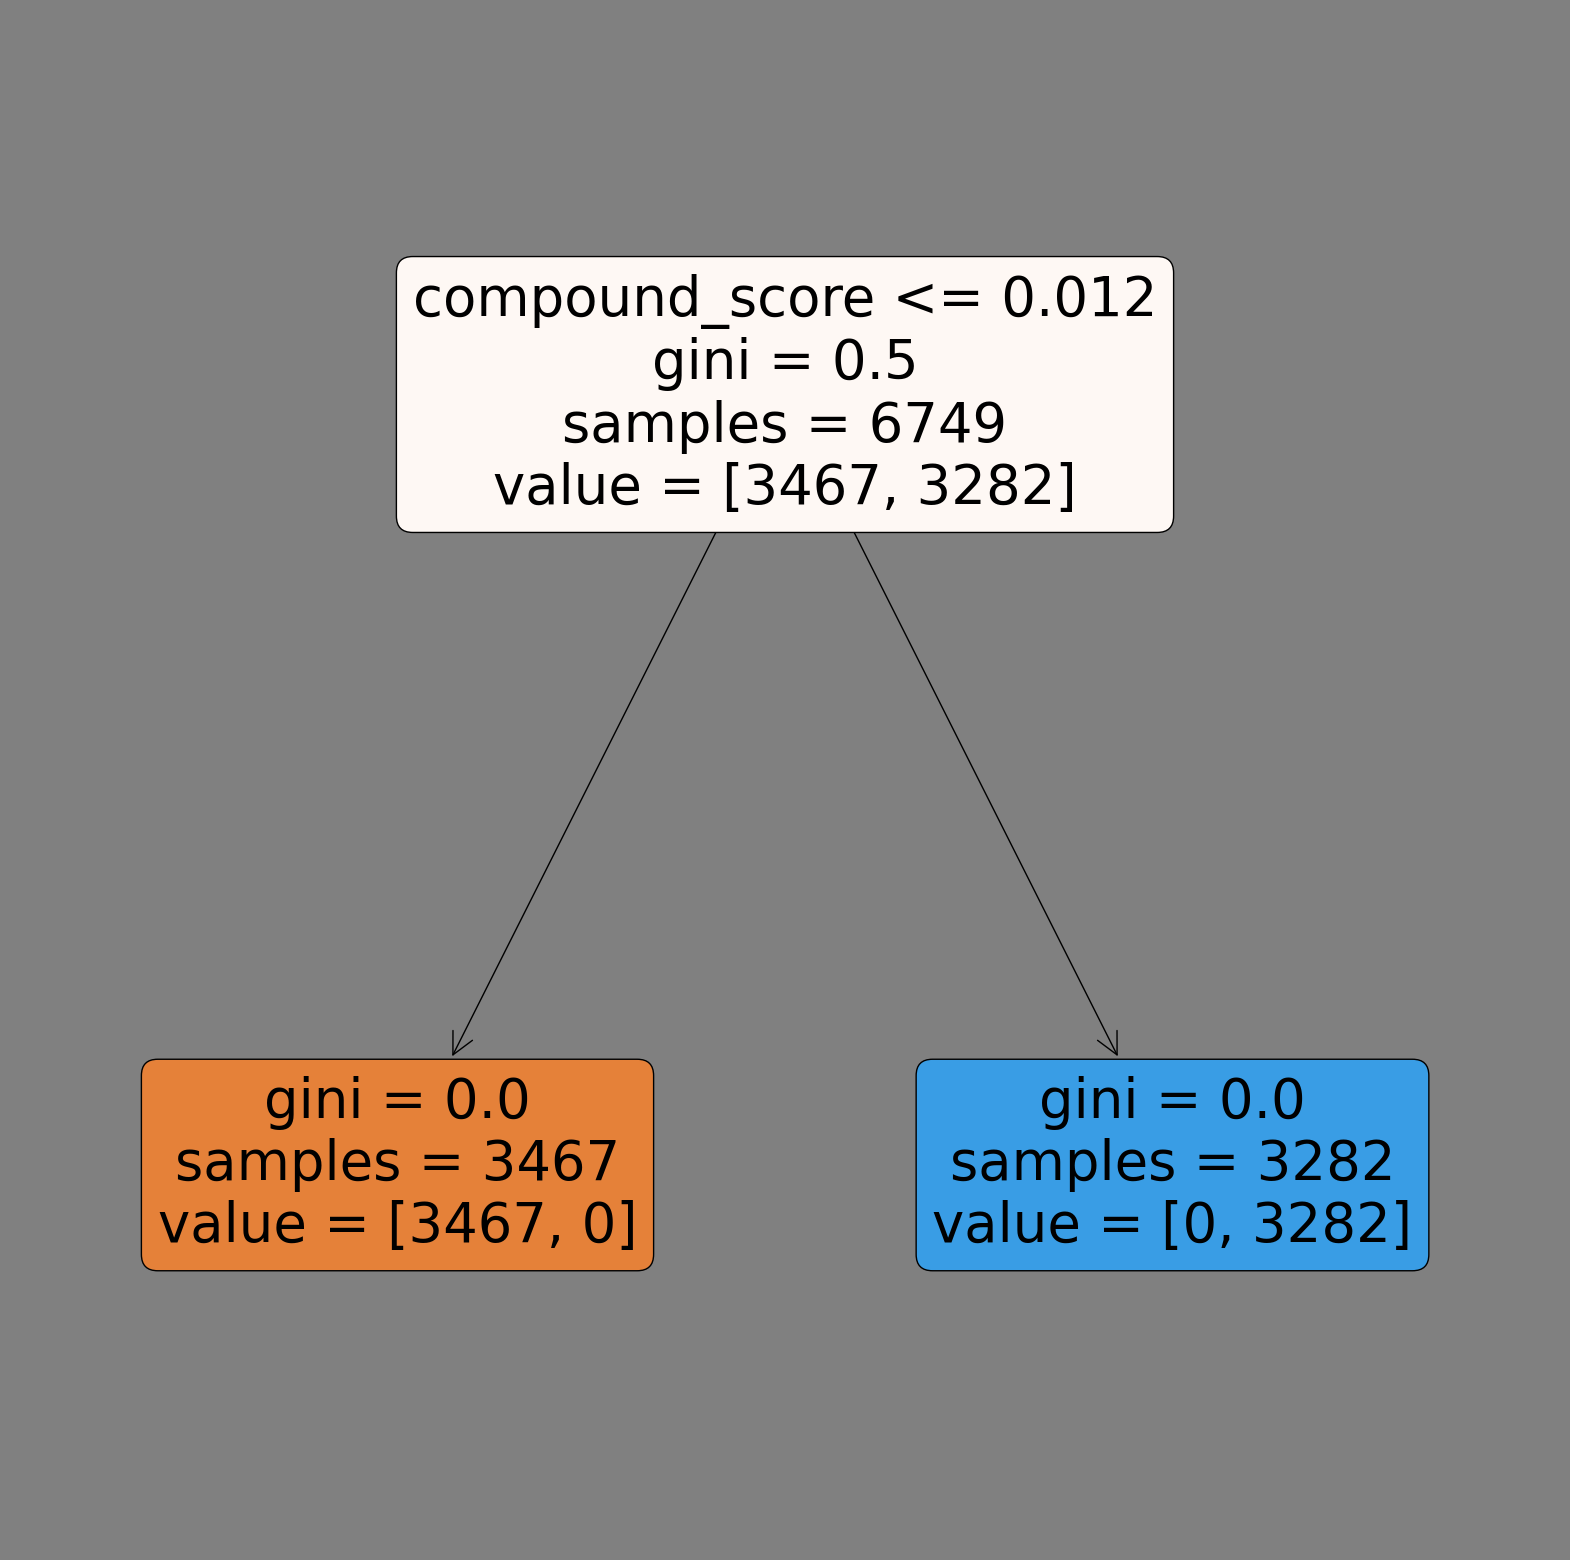

In [ ]:
# Visualize the tree using tree.plot_tree
import matplotlib.pyplot as plt
from sklearn import tree
fig, ax = plt.subplots(figsize=(20,20), facecolor="gray")
tree.plot_tree(dtree, feature_names=X.columns, filled=True, rounded=True)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
y_pred = dtree.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

1.0

# DT Pruning

In [ ]:
dtree_ccp = dtree.cost_complexity_pruning_path(X_train, y_train)

In [ ]:
dtree_ccp

{'ccp_alphas': array([0.        , 0.49962431]),
 'impurities': array([0.        , 0.49962431])}

In [ ]:
ccp_alphas, impurities = dtree_ccp.ccp_alphas, dtree_ccp.impurities

Text(0.5, 1.0, 'Total Impurity vs Effective Alpha for training set')

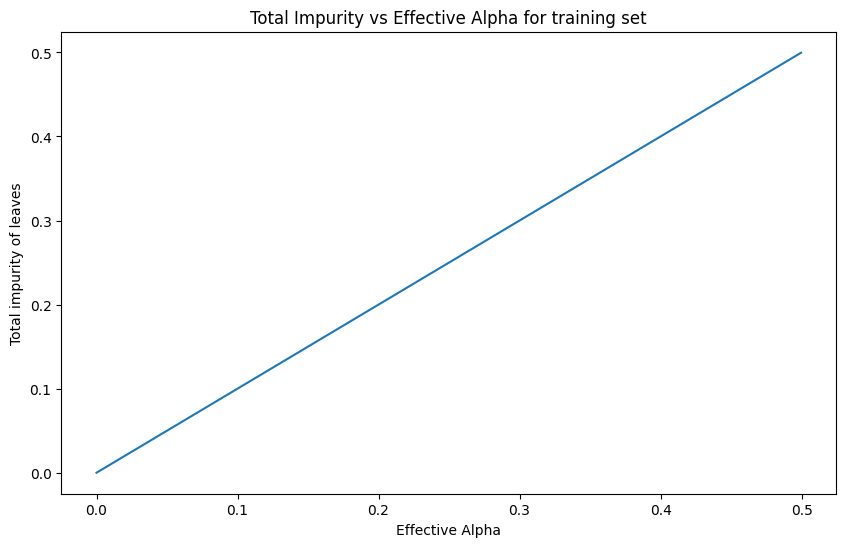

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(ccp_alphas, impurities)
plt.xlabel("Effective Alpha")
plt.ylabel("Total impurity of leaves")
plt.title("Total Impurity vs Effective Alpha for training set")

In [ ]:
param_grid = {"ccp_alpha": ccp_alphas,
              "max_depth": range(1,11),
              "min_samples_leaf": range(1,11),
              "criterion": ["gini", "entropy"]}

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
search = GridSearchCV(dtree,
                      param_grid,
                      cv=10,
                      scoring="roc_auc")

In [ ]:
search_fit = search.fit(X_train, y_train)

In [ ]:
pd.DataFrame(search_fit.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005313,0.001985,0.006271,0.003985,0.0,gini,1,1,"{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_d...",1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
1,0.005469,0.002350,0.004533,0.000284,0.0,gini,1,2,"{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_d...",1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
2,0.005543,0.002728,0.004707,0.000361,0.0,gini,1,3,"{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_d...",1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
3,0.005436,0.002263,0.006903,0.004309,0.0,gini,1,4,"{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_d...",1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
4,0.008054,0.004389,0.007719,0.004064,0.0,gini,1,5,"{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_d...",1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.003149,0.000654,0.003025,0.000791,0.499624,entropy,10,6,"{'ccp_alpha': 0.49962430570101857, 'criterion'...",1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
396,0.002734,0.000095,0.002522,0.000073,0.499624,entropy,10,7,"{'ccp_alpha': 0.49962430570101857, 'criterion'...",1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
397,0.002726,0.000155,0.002492,0.000058,0.499624,entropy,10,8,"{'ccp_alpha': 0.49962430570101857, 'criterion'...",1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
398,0.002784,0.000284,0.002554,0.000133,0.499624,entropy,10,9,"{'ccp_alpha': 0.49962430570101857, 'criterion'...",1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1


In [ ]:
pd.DataFrame(search_fit.cv_results_). sort_values("rank_test_score")[["param_ccp_alpha", "param_criterion", "param_max_depth", "param_min_samples_leaf"]]

,param_ccp_alpha,param_criterion,param_max_depth,param_min_samples_leaf
0,0.0,gini,1,1
303,0.499624,entropy,1,4
302,0.499624,entropy,1,3
301,0.499624,entropy,1,2
300,0.499624,entropy,1,1
...,...,...,...,...
247,0.499624,gini,5,8
246,0.499624,gini,5,7
245,0.499624,gini,5,6
243,0.499624,gini,5,4


In [ ]:
from sklearn.tree import export_text

In [ ]:
tree_rules = export_text(search_fit.best_estimator_, feature_names=list(X))

In [ ]:
print(tree_rules)

|--- compound_score <= 0.01
|   |--- class: 0
|--- compound_score >  0.01
|   |--- class: 1



In [ ]:
search_fit.best_estimator_.feature_importances_

array([1., 0.])

In [ ]:
for name, value in sorted(zip(X.columns, search_fit.best_estimator_.feature_importances_)):
  print(f'{name} importance = {100.0 * value:5.2f}%')

compound_score importance = 100.00%
rating importance =  0.00%


Text(0.5, 1.0, 'Feature Importance')

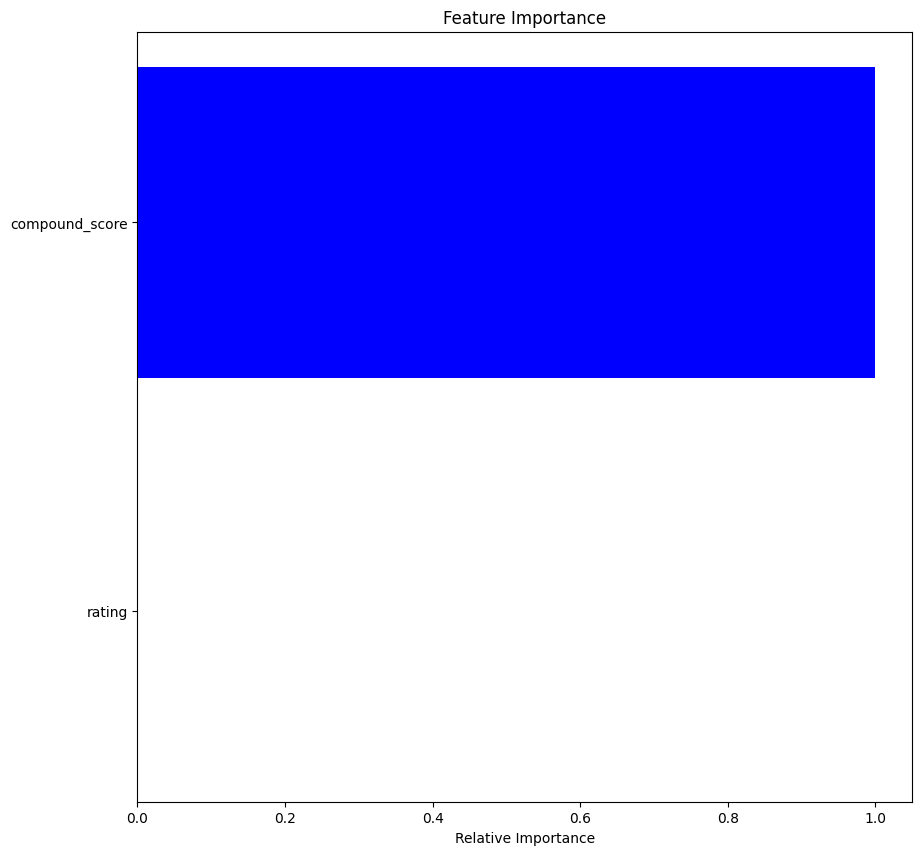

In [ ]:
import numpy as np
plt.figure(figsize=(10,10))

features = X.columns
importance = search_fit.best_estimator_.feature_importances_
indices = np.argsort(importance)

num_features = len(X.columns)

#plot feature importance
plt.barh(range(num_features), importance[indices[-num_features:]], color='b', align='center')
plt.yticks(range(num_features), [features[i] for i in indices [-num_features:]])

# labels
plt.xlabel('Relative Importance')
plt.title('Feature Importance')

In [ ]:
y_pred = search_fit.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[1482,    0],
       [   0, 1411]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1482
           1       1.00      1.00      1.00      1411

    accuracy                           1.00      2893
   macro avg       1.00      1.00      1.00      2893
weighted avg       1.00      1.00      1.00      2893



In [ ]:
from sklearn.metrics import RocCurveDisplay

Text(0.5, 1.0, ' ROC Curve ')

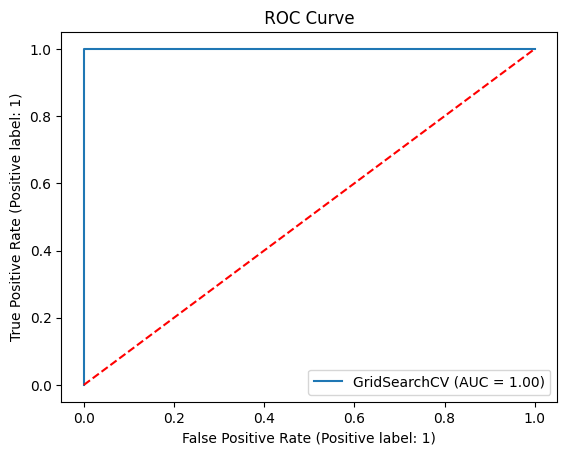

In [ ]:
dt_disp = RocCurveDisplay.from_estimator(search_fit, X_test, y_test)

plt.plot([0,1], [0,1], color = 'r', linestyle = '--')
plt.title(' ROC Curve ')